<a href="https://colab.research.google.com/github/ykitaguchi77/CongenitalGlaucoma_AI_project/blob/main/YOLOv5_Periocular_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Periocular_annotations_for_YOLOv5**

In [2]:
import pandas as pd
import os
import glob
import shutil
import glob
import random
from PIL import Image
import time
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2


# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# 患者のリスト(緑内障のみ)
csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df

,id,R,L
0,1546,0,1
1,1962,1,1
2,2004,1,0
3,2223,1,0
4,2761,0,1
5,3229,1,0
6,3422,1,1
7,379,1,1
8,4377,1,0
9,4407,1,0


In [ ]:
# glaucoma_extended datasetをcolab上に解凍する
%cd /content
!cp "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/glaucoma_extended_dataset.zip" .
!unzip glaucoma_extended_dataset.zip



In [ ]:
#glaucoma患者のリストを作成
image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/dataset_for_YOLO_1280px"


gla_folder = ["gla_eso", "gla_exo", "gla_ortho"]

patient_id_list = []
for folder in gla_folder:
    file_list = [os.path.basename(i).split('-')[0].split('_')[0] for i in glob.glob(f"{image_dir}/{folder}/*")]
    patient_id_list.extend(file_list)

patient_id_list = sorted(list(set(patient_id_list)))
print(patient_id_list)
len(patient_id_list)


['1546', '1962', '2004', '2223', '2761', '3229', '3422', '379', '4377', '4407', '4725', '4849', '5393', '5617', '5821', '6668', '6821', '6895', '713', '7154', '7495', '781', '8126', '8128', '8193', '8246', '8294', '8425', '8492', '8500', '8698', '8882', '8921', '9056', '9201']


35

In [ ]:
df_patient_data = pd.DataFrame(index=[], columns=[])
df_patient_data["id"] = patient_id_list
df_patient_data

In [ ]:
#patient_idの入った空のリストをセーブ

new_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
os.makedirs(new_dir)

df_patient_data.to_csv(f"{new_dir}/patient_data_vacant.csv")


idの横にRとLの列を作成

混濁していたら1を記入

patient_data.csvとして保存

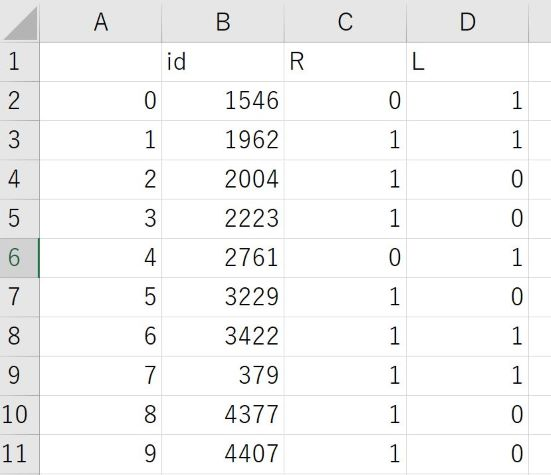

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df



#**Extract periocular images and annotate with dataframe**

## Haarcascadeを指定

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'
# righteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_righteye_2splits.xml'
# lefteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_lefteye_2splits.xml'


# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# righteye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# lefteye_cascade = cv2.CascadeClassifier(eye_cascade_path)

## 眼周囲切り抜き

class_num = 4



0: 右眼、濁りなし

1: 右眼、濁りあり

2: 左眼、濁りなし

3: 左眼、濁りあり

In [ ]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

# def show_image_pillow(img):
#     src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

def scale_to_width(img, width):
    """幅が指定した値になるように、アスペクト比を固定して、リサイズする。
    """
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))

    return dst

In [ ]:
orig_folder = "/content/dataset_extended"
dst_folder = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images"
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(dst_folder)


path_list = glob.glob(orig_folder+"/*")
#path_list = [path_list[2]] #テスト用
#path_list = path_list[1:30] #テスト用
#path_list = ["/content/dataset_extended/9201-20210304-0-113733_2fa4e6a541d752afc0c740c856f0fbce9a435341353847cb60b6732b055989df.jpg"]


dst_folder = dst_folder

#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/images") #image格納用
os.makedirs(f"{dst_folder}/images_cropped") #cropped_image格納用 (YOLOでは使用しない)
os.makedirs(f"{dst_folder}/labels") #label格納用


num=0
showImage = True
for path in path_list:
    try: #目が検出されなかった場合のエラー回避。片目ずつ抜き出して保存
        #img2 = cv2.imread(path).copy()

        img_resized_list,side_list = [],[]

        img = cv2.imread(path) 
        img2 = img.copy()

        #画像を表示
        # if showImage:
        #     show_image(img)

        # 画像グレースケール化
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #300pix以上のもので目に見えるものを抽出
        eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
        print("")
        print('image path = ', path)

        # 眼検出判定
        if len(eye_list) >= 1:
            print('目が' + str(len(eye_list)) +'個検出されました')
            pass
        else:
            print("no eye detected")
            pass

        print(f"eye_list: {eye_list}")

        #画像の切り抜きと保存（連番にする）
        if len(eye_list)== 2: 

            ex1, ey1, ew1, eh1 = eye_list[0]
            ex2, ey2, ew2, eh2 = eye_list[1]


            print(f"ex1: {ex1}, ex2: {ex2}, img2.shape: {img2.shape}")

            # 両眼がセンターラインを挟んで左右にあることを確認
            if (ex1+ew1/2 < img2.shape[1] / 2 and ex2+ew2/2 < img2.shape[1] / 2) or (ex1+ew1/2 > img2.shape[1] / 2 and ex2+ew2/2 > img2.shape[1] / 2):
                raise ValueError("The eyes must be on opposite sides of the face")
            

            
            
            for (ex, ey, ew, eh) in eye_list:
                print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
 
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, int(ey))
                bottom = min(grayscale_img.shape[0], int(ey + eh))
                left = max(0, int(ex))
                right = min(grayscale_img.shape[1], int(ex + ew))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                # if showImage:
                #     show_image(img_cropped)


                #右か左かの判定
                if left >= img.shape[1]/2:
                    laterality = "L"
                elif right <= img.shape[1]/2:
                    laterality = "R"
                print(laterality)

                #混濁の有無（dfより抽出）
                id = os.path.basename(path).split("-")[0]

                if (df['id'] == int(id)).any(): #glaのリストに含まれているかどうか
                    if laterality == "R":
                        if df.loc[df['id'] == int(id), "R"].values[0] == 0:
                            class_num = 0 #右眼かつ混濁なし
                        elif df.loc[df['id'] == int(id), "R"].values[0] == 1:
                            class_num = 1 #右眼かつ混濁あり
                    elif laterality == "L":
                        if df.loc[df['id'] == int(id), "L"].values[0] == 0:
                            class_num = 2 #左眼かつ混濁なし
                        elif df.loc[df['id'] == int(id), "L"].values[0] == 1:
                            class_num = 3 #左眼かつ混濁あり

                elif not (df['id'] == int(id)).any(): #glaのリストに含まれていない場合
                    if laterality == "R":
                        class_num = 0 #右眼かつ混濁なし
                    elif laterality == "L":
                        class_num = 2 #左眼かつ混濁なし

                print(f"class_num: {class_num}")

                #縦、横に対する割合
                X = round((right+left)/2/img.shape[1], 6)
                Y = round((top+bottom)/2/img.shape[0], 6)
                W = round((right-left)/img.shape[1], 6)
                H = round((bottom-top)/img.shape[0], 6)
                txt = f"{class_num} {X} {Y} {W} {H}"

                img2 = scale_to_width(img2, 640)  #切り抜く前の画像を横のサイズを640になるように縮小
                cv2.imwrite(f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG", img) #cropせずに縮小したイメージを保存
                cv2.imwrite(f"{dst_folder}/images_cropped/{os.path.basename(path).split('.')[0]}_{laterality}.JPG", img_cropped) #cropしたイメージを保存する場合

                with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='a') as f:
                    f.write(f"{txt}\n")     

                num+=1

            with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='r') as f:
                for line in f:
                    print(line) # 1行ずつ表示
    except:
        pass

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")

#**画像の選別**

・images_pathとimages_cropped_pathから不適切な画像を削除（眼の切り取り範囲がおかしい、眼鏡をかけているなど）

・imaes_pathに画像がある、images_cropped_pathに画像が2つ（RとL）ある、label_pathのtxtが2行（RとL)の全てを満たすもののみを残して
、あとは削除する（※バックアップのため、元フォルダを_backupに改名）

In [ ]:
import os
import shutil
import tqdm

patient_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images"
orig_label_dir = f"{patient_dir}/labels"
orig_images_cropped_dir = f"{patient_dir}/images_cropped"
orig_images_dir = f"{patient_dir}/images"
dst_label_dir = f"{patient_dir}/labels_selected"
dst_images_cropped_dir = f"{patient_dir}/images_cropped_selected"
dst_images_dir = f"{patient_dir}/images_selected"

# Create destination folders
for dir in [dst_label_dir, dst_images_cropped_dir, dst_images_dir]:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)


# images_pathの画像リスト
images_list = glob.glob(f"{orig_images_dir}/*")
images_name_list = [os.path.splitext(os.path.basename(path))[0] for path in images_list]

# images_cropped_pathの画像リスト
images_cropped_list = glob.glob(f"{orig_images_cropped_dir}/*")
print(images_cropped_list)

# Labelのリスト
label_list = glob.glob(f"{orig_label_dir}/*")

from tqdm import tqdm

# 2行でないlabelファイルを削除
for filename in tqdm(os.listdir(orig_label_dir),desc='checking label files'):
    if filename.endswith(".txt"):
        file_path = os.path.join(orig_label_dir, filename)
        with open(file_path, 'r') as f:
            if len(f.readlines()) != 2:
                os.remove(file_path)
                print("label_file removed!")

for file in tqdm(images_name_list,desc='copying files'): #images_listの画像に対して
    if f"{orig_images_cropped_dir}/{file}_R.JPG" in images_cropped_list: #Rがあるかをチェック
        if f"{orig_images_cropped_dir}/{file}_L.JPG" in images_cropped_list: #Lがあるかをチェック
            if f"{orig_label_dir}/{file}.txt" in label_list:
                shutil.copy(f"{orig_images_cropped_dir}/{file}_R.JPG", dst_images_cropped_dir)
                shutil.copy(f"{orig_images_cropped_dir}/{file}_L.JPG", dst_images_cropped_dir)
                shutil.copy(f"{orig_images_dir}/{file}.JPG", dst_images_dir)
                shutil.copy(f"{orig_label_dir}/{file}.txt", dst_label_dir)
                #print(f"{file} moved!!")
print("")
print(f"images: {len(os.listdir(dst_images_dir))}")
print(f"images: {len(os.listdir(dst_label_dir))}")

In [ ]:
# imagesとlabelsで片方にしかないファイルを削除（本当はこんなことは無いはずだが...）
import os

image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/train/images"
label_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/train/labels"

# Get basenames of images
image_basenames = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
print(len(image_basenames))

# Get basenames of labels
label_basenames = [os.path.splitext(f)[0] for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
print(len(label_basenames))

# Check if basenames are the same
if set(image_basenames) != set(label_basenames):
    # Get unique basenames
    unique_basenames = set(image_basenames) & set(label_basenames)
    print(len(unique_basenames))
    
    # Remove files with unique basenames
    for basename in image_basenames:
        if basename not in unique_basenames:
            os.remove(f"{image_dir}/{basename}.JPG")
            print(f"{image_dir}/{basename}.JPG removed")

    for basename in label_basenames:
        if basename not in unique_basenames:
            os.remove(f"{image_dir}/{basename}.JPG")
            print(f"{label_dir}/{basename}.JPG removed")

# **YOLO_v5 training用フォルダを作成**

datasetをtrainとvalに分ける

https://book.st-hakky.com/docs/object-detection-yolov5-tutorial/

In [ ]:
"""

/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLO_training
-----dataset-----train-----images
              |         |--labels 
              |--valid-----images
              |         |--labels
              |--dataset.yaml


"""

'\n\n/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLO_training\n-----dataset-----train-----images\n              |         |--labels \n              |--valid-----images\n              |         |--labels\n              |--dataset.yaml\n\n\n'

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import shutil
import random
from sklearn.model_selection import GroupKFold
random.seed(1)

# トレイン用のフォルダパス
train_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training"
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

train_images_dir = f"{train_dir}/train/images"
train_labels_dir = f"{train_dir}/train/labels"
valid_images_dir = f"{train_dir}/valid/images"
valid_labels_dir = f"{train_dir}/valid/labels"
os.makedirs(f"{train_dir}/train")
os.makedirs(train_images_dir)
os.makedirs(train_labels_dir)
os.makedirs(f"{train_dir}/valid")
os.makedirs(valid_images_dir)
os.makedirs(valid_labels_dir)


# 画像が格納されているディレクトリのパス
image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images/images_selected"
label_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images/labels_selected"


# ファイル名のリストを作成
file_list = glob.glob(f"{image_dir}/*")
basename_list = [os.path.basename(file) for file in file_list]

# idを抽出してリスト化
ids = []
for file_name in basename_list:
    id = file_name.split("-")[0]
    ids.append(id)
# ids = list(set(ids))

# GroupKFoldによる分割
gkf = GroupKFold(n_splits=5)
X = file_list
y = [0]*len(file_list)
groups = ids
for train_index, valid_index in gkf.split(X, y, groups):
    train_files = [basename_list[i] for i in train_index]
    valid_files = [basename_list[i] for i in valid_index]


from tqdm import tqdm

train_index, valid_index = next(gkf.split(X, y, groups))
train_files = [basename_list[i] for i in train_index]
valid_files = [basename_list[i] for i in valid_index]

# ファイルのコピー
for file_name in tqdm(train_files, desc='Copying training files'):
    src_image_path = os.path.join(image_dir, file_name)
    dst_image_path = os.path.join(train_images_dir, file_name)    
    shutil.copy(src_image_path, dst_image_path)
    src_label_path = os.path.join(label_dir, os.path.splitext(file_name)[0] + ".txt")
    dst_label_path = os.path.join(train_labels_dir, os.path.splitext(file_name)[0] + ".txt")
    shutil.copy(src_label_path, dst_label_path)

for file_name in tqdm(valid_files, desc='Copying validation files'):
    src_image_path = os.path.join(image_dir, file_name)
    dst_image_path = os.path.join(valid_images_dir, file_name)
    shutil.copy(src_image_path, dst_image_path)
    src_label_path = os.path.join(label_dir, os.path.splitext(file_name)[0] + ".txt")
    dst_label_path = os.path.join(valid_labels_dir, os.path.splitext(file_name)[0] + ".txt")
    shutil.copy(src_label_path, dst_label_path)

print("")
print(f"train_images: {len(os.listdir(train_images_dir))}")
print(f"train_labels: {len(os.listdir(train_labels_dir))}")
print(f"valid_images: {len(os.listdir(valid_images_dir))}")
print(f"valid_labels: {len(os.listdir(valid_labels_dir))}")

Copying validation files: 100%|██████████| 159/159 [02:08<00:00,  1.23it/s]


train: 635
valid: 159


In [ ]:
# imagesとlabelsで片方にしかないファイルを削除（本当はこんなことは無いはずだが...）
import os

image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/train/images"
label_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/train/labels"

# Get basenames of images
image_basenames = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
print(len(image_basenames))

# Get basenames of labels
label_basenames = [os.path.splitext(f)[0] for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
print(len(label_basenames))

# Check if basenames are the same
if set(image_basenames) != set(label_basenames):
    # Get unique basenames
    unique_basenames = set(image_basenames) & set(label_basenames)
    print(len(unique_basenames))
    
    # Remove files with unique basenames
    for basename in image_basenames:
        if basename not in unique_basenames:
            os.remove(f"{image_dir}/{basename}.JPG")
            print(f"{image_dir}/{basename}.JPG removed")

    for basename in label_basenames:
        if basename not in unique_basenames:
            os.remove(f"{image_dir}/{basename}.JPG")
            print(f"{label_dir}/{basename}.JPG removed")

635
635


In [ ]:
%cd $train_dir

/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training


In [ ]:
%%writefile dataset.yaml
# path
train: /content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/train/images
val: /content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/valid/images

# num of classes
nc: 4

#class names
names: ['R_normal', 'R_gla', 'L_normal', 'L_gla'] # class名を定義

Writing dataset.yaml


#**Setup YOLO5**

In [ ]:
#train_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training"

%cd /content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 27.2/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
yaml_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/dataset.yaml"

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 300 --data $yaml_path --weights yolov5n.pt


train: weights=yolov5n.pt, cfg=, data=/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, 

#**Interference YOLOv5n**

In [5]:
model_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/gla_yolo5n_300epochs.pt"

In [6]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 25.5/166.8 GB disk)


In [22]:
# YOLOv5
weight = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/gla_yolov5n_300epochs.pt"

# 横幅を640pxにリサイズしたデータセット(validation_set)
dataset = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/valid/images"

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[440.37012, 288.92050, 588.71741, 437.70309,   0.92647,   2.00000],
        [ 82.55758, 281.22711, 216.05313, 415.54724,   0.90767,   0.00000]])]
診断は L_normal、確率は92.6％です。
診断は R_normal、確率は90.8％です。


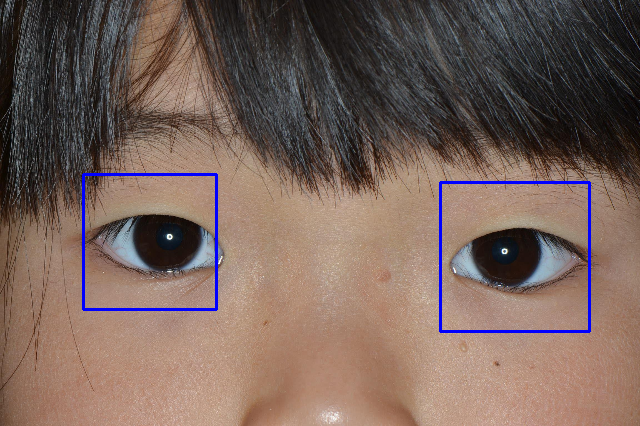

In [37]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.6, iou_thres=0.8, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred
     

image_path = glob.glob(f"{dataset}/*")
img = image_path[30]

class_names = {0:"R_normal", 1:"R_gla", 2:"L_normal", 3:"L_gla"}
pred = interference(img, weight)


img_cv2 = cv2.imread(img) 

# 横幅を640pixにリサイズ
width = 640
height = int(img_cv2.shape[0] * width / img_cv2.shape[1])
img_cv2 = cv2.resize(img_cv2, (width, height))

for idx_boxes, boxes in enumerate(pred[0]):
    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][idx_boxes])

    # probability
    prob = pred[0][idx_boxes][4].item()

    # class
    class_name = class_names[pred[0][idx_boxes][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    #print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")


    # draw bounding box
    cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)


# show image
cv2_imshow(img_cv2)

In [39]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  error: subprocess-exited-with-error
  
  × Running setup.py install for scikit-learn did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for scikit-learn ... error
  Rolling back uninstall of scikit-learn
  Moving to /usr/local/lib/python3.9/dist-packages/scikit_learn-1.2.2.dist-info/
   from /usr/local/lib/python3.9/dist-packages/

In [40]:
weight_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_for_YOLO_training/gla_yolov5n_300epochs.pt"


In [ ]:
!python export-nms.py --include coreml --weights $weight_path --conf-thres 0.6 --iou-thres 0.8
